### Tutorial #6: Applying Machine Learning Methods to Temporal Dimensions of EEG Data on Participant Level

In this tutorial, same classification tasks in last two tutorails will be examined on temporal dimensions of eeg data.

In this strategy, selected model will be fitted to each time instance and performance of the model at each time instance will be evaluated on the same time instance in new epochs. 

SlidingEstimator in MNE package is provided for this purpose. It takes the model and optionally a scoring function as parameters to create a sliding estimator. After having created a sliding estimator, it can be fitted to the data, scored the estimator on each task or made predictions on new epochs.

In [1]:
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from mne.decoding import Vectorizer

from os.path import isfile, join
from os import listdir
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [3]:
#Load Dataset
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]
#files = files[:10]
ids = [int(f[-6:-4]) for f in files]

numberOfEpochs = np.zeros((len(ids), 3))
# Read the EEG epochs:
epochs_all_UN, epochs_all_UP, epochs_all_NP = [], [], []
for f in range(len(files)):
    epochs = mne.read_epochs(files[f], verbose=False)
    epochs_UN = epochs['FU', 'FN']
    epochs_UP = epochs['FU', 'FP']
    epochs_NP = epochs['FN', 'FP']
    numberOfEpochs[f,0] = int(len(epochs_UN.events))
    numberOfEpochs[f,1] = int(len(epochs_UP.events))
    numberOfEpochs[f,2] = int(len(epochs_NP.events))
    UN, UP, NP = [ids[f]], [ids[f]], [ids[f]]
    UN.append(epochs_UN)
    UP.append(epochs_UP)
    NP.append(epochs_NP)
    epochs_all_UN.append(UN)
    epochs_all_UP.append(UP)
    epochs_all_NP.append(NP)

#print(numberOfEpochs)
epochs_all_UN = np.array(epochs_all_UN)
epochs_all_UP = np.array(epochs_all_UP)
epochs_all_NP = np.array(epochs_all_NP)

<ipython-input-3-28d4ed2bad30>:11: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-15.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(files[f], verbose=False)
<ipython-input-3-28d4ed2bad30>:11: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(files[f], verbose=False)
<ipython-input-3-28d4ed2bad30>:11: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(files[f], verbose=False)
<ipython-input-3-28d4ed2bad30>:11: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-02.fif) does not conform to MNE naming c

In [4]:
def getData_labels(epochs):
    data, labels, ids = [], [], []
    for p in epochs:
        tmp_epoch = p[1]
        tmp_labels = tmp_epoch.events[:,-1]
        labels.extend(tmp_labels)
        tmp_id = p[0]
        ids.extend([tmp_id]*len(tmp_labels))        
        data.extend(tmp_epoch.get_data())
        
    data = np.array(data)
    labels = np.array(labels)
    ids = np.array(ids)
    return data, labels, ids

### Task #1: Classification of Unpleasant and Pleasant Events

In [7]:
#Preparing dataset
data_UP, labels_UP, ids_UP = getData_labels(epochs_all_UP)
print(np.all(np.isfinite(labels_UP)))
print(np.any(np.isnan(labels_UP)))
if np.isfinite(data_UP).all() == True and np.isnan(data_UP).any() == False:
    print('not nan')
else:
    print('Nan')

True
False
not nan


In [24]:
clf_UP = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_UP = SlidingEstimator(clf_UP, scoring='accuracy') 
if np.isfinite(data_UP).all() == True and np.isnan(data_UP).any() == False:
    CV_score_time = cross_val_multiscore(sl_UP, data_UP, labels_UP, cv=3)
    print(CV_score_time)
else:
    print('Input contains NaN or infinity!')

[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[[0.4408078  0.44498607 0.44428969 ... 0.43001393 0.43175487 0.43593315]
 [0.45191638 0.44041812 0.44006969 ... 0.44181185 0.44181185 0.44634146]
 [0.44979079 0.44874477 0.45048815 ... 0.4539749  0.45292887 0.45048815]]


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotCVScores(times, CV_score_time):
    fig, ax = plt.subplots()
    fig.suptitle('CV Scores')
    ax.plot(epochs_UP.times, CV_score_time.T)
    plt.xlabel('Time')
    plt.ylabel('Area Under the ROC Curve')
    plt.show()


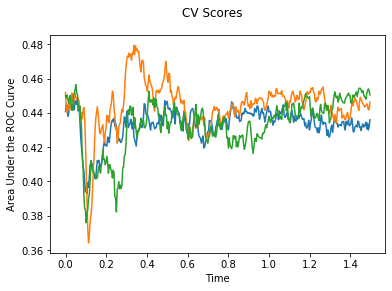

In [26]:
plotCVScores(epochs_UP.times, CV_score_time)

### Task #2: Classification of Unpleasant and Neutral Events

In [27]:
#Preparing dataset
data_UN, labels_UN, ids_UN = getData_labels(epochs_all_UN)

[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[[0.32517483 0.31713287 0.31713287 ... 0.31083916 0.30909091 0.30839161]
 [0.30545836 0.30790763 0.31105668 ... 0.30860742 0.30720784 0.31210637]
 [0.3139657  0.30836542 0.30486524 ... 0.32446622 0.32306615 0.32831642]]


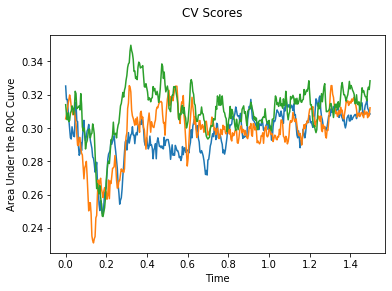

In [28]:
clf_UN = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_UN = SlidingEstimator(clf_UN, scoring='accuracy') 
if np.isfinite(data_UN).all() == True and np.isnan(data_UN).any() == False:
    CV_score_time = cross_val_multiscore(sl_UN, data_UN, labels_UN, cv=3)
    print(CV_score_time)
    plotCVScores(epochs_UN.times, CV_score_time)
else:
    print('Input contains NaN or infinity!')

### Task #3: Classification of Neutral and Pleasant Events

In [29]:
#Preparing dataset
data_NP, labels_NP, ids_NP = getData_labels(epochs_all_NP)

[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[[0.44455923 0.4411157  0.44524793 ... 0.44249311 0.44421488 0.44283747]
 [0.44574578 0.44815708 0.44161213 ... 0.43678953 0.43506717 0.43575611]
 [0.44068966 0.44103448 0.44482759 ... 0.44068966 0.44068966 0.43931034]]


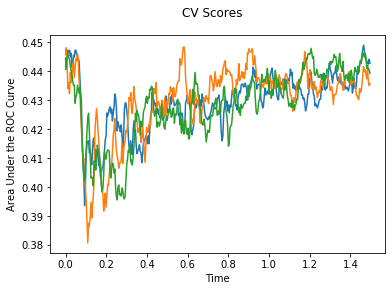

In [30]:
clf_NP = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_NP = SlidingEstimator(clf_NP, scoring='accuracy') 
if np.isfinite(data_NP).all() == True and np.isnan(data_NP).any() == False:
    CV_score_time = cross_val_multiscore(sl_NP, data_NP, labels_NP, cv=3)
    print(CV_score_time)
    plotCVScores(epochs_NP.times, CV_score_time)
else:
    print('Input contains NaN or infinity!')